In [17]:
from lemat_genbench.benchmarks.validity_benchmark import ValidityBenchmark
from typing import Any, Dict, List

from lemat_genbench.preprocess.validity_preprocess import ValidityPreprocessor
from lemat_genbench.utils.logging import logger
from pathlib import Path
from tqdm import tqdm
from datasets import load_dataset
import numpy as np
import pandas as pd
from pymatgen.core import Structure
import time 
import gc
import torch
import smact
from smact.screening import smact_filter, smact_validity
from sklearn.metrics import r2_score

In [18]:
def lematbulk_item_to_structure(item: dict):
    sites = item["species_at_sites"]
    coords = item["cartesian_site_positions"]
    cell = item["lattice_vectors"]

    structure = Structure(
        species=sites, coords=coords, lattice=cell, coords_are_cartesian=True
    )

    return structure

In [19]:
def run_validity_preprocessing_and_filtering(
    structures, config: Dict[str, Any], monitor_memory: bool = False
):
    """Run validity benchmark and preprocessing, then filter to valid structures only.

    Returns
    -------
    tuple
        (validity_benchmark_result, valid_structures, validity_filtering_metadata)
    """
    # Log initial memory usage

    n_total_structures = len(structures)
    logger.info(
        f"🔍 Starting MANDATORY validity processing for {n_total_structures} structures..."
    )

    # Step 1: Run validity benchmark on ALL structures
    logger.info("🔍 Running MANDATORY validity benchmark on ALL structures...")
    start_time = time.time()

    validity_settings = config.get("validity_settings", {})
    validity_benchmark = ValidityBenchmark(
        charge_tolerance=validity_settings.get("charge_tolerance", 0.1),
        distance_scaling=validity_settings.get("distance_scaling", 0.5),
        min_density=validity_settings.get("min_density", 0.01),
        max_density=validity_settings.get("max_density", 25.0),
        check_format=validity_settings.get("check_format", True),
        check_symmetry=validity_settings.get("check_symmetry", True),
    )

    validity_benchmark_result = validity_benchmark.evaluate(structures)

    elapsed_time = time.time() - start_time
    logger.info(
        f"✅ MANDATORY validity benchmark complete for {n_total_structures} structures in {elapsed_time:.1f}s"
    )

    # Clean up after validity benchmark
    cleanup_after_benchmark("validity", monitor_memory)

    # Step 2: Run validity preprocessor on ALL structures
    logger.info("🔍 Running MANDATORY validity preprocessor on ALL structures...")
    start_time = time.time()

    charge_tolerance = validity_settings.get("charge_tolerance", 0.1)
    distance_scaling = validity_settings.get("distance_scaling", 0.5)
    min_density = validity_settings.get("min_density", 0.01)
    max_density = validity_settings.get("max_density", 25.0)
    check_format = validity_settings.get("check_format", True)
    check_symmetry = validity_settings.get("check_symmetry", True)

    validity_preprocessor = ValidityPreprocessor(
        charge_tolerance=charge_tolerance,
        distance_scaling_factor=distance_scaling,
        plausibility_min_density=min_density,
        plausibility_max_density=max_density,
        plausibility_check_format=check_format,
        plausibility_check_symmetry=check_symmetry,
    )

    # Create source IDs for tracking
    structure_sources = [f"structure_{i}" for i in range(len(structures))]
    validity_preprocessor_result = validity_preprocessor.run(
        structures, structure_sources=structure_sources
    )
    processed_structures = validity_preprocessor_result.processed_structures

    elapsed_time = time.time() - start_time
    logger.info(
        f"✅ MANDATORY validity preprocessing complete for {len(processed_structures)} structures in {elapsed_time:.1f}s"
    )

    # Clean up after validity preprocessor
    cleanup_after_preprocessor("validity", monitor_memory)

    # Step 3: Filter to only valid structures
    logger.info("🔍 Filtering to valid structures only...")

    valid_structures = []
    valid_structure_ids = []
    valid_structure_sources = []

    for structure in processed_structures:
        is_valid = structure.properties.get("overall_valid", False)
        if is_valid:
            valid_structures.append(structure)
            valid_structure_ids.append(
                structure.properties.get("structure_id", "unknown")
            )
            valid_structure_sources.append(
                structure.properties.get("original_source", "unknown")
            )

    n_valid_structures = len(valid_structures)
    n_invalid_structures = n_total_structures - n_valid_structures

    # Log filtering results
    logger.info(
        f"✅ Filtering complete: {n_valid_structures} valid structures out of {n_total_structures} total"
    )
    logger.info(f"📊 Valid: {n_valid_structures}, Invalid: {n_invalid_structures}")

    if n_valid_structures == 0:
        logger.warning(
            "⚠️  No valid structures found! All subsequent benchmarks will be skipped."
        )

    # Create filtering metadata
    validity_filtering_metadata = {
        "total_input_structures": n_total_structures,
        "valid_structures": n_valid_structures,
        "invalid_structures": n_invalid_structures,
        "validity_rate": n_valid_structures / n_total_structures
        if n_total_structures > 0
        else 0.0,
        "valid_structure_ids": valid_structure_ids,
        "valid_structure_sources": valid_structure_sources,
    }

    # Log final memory usage
    # log_memory_usage("after validity filtering", force_log=monitor_memory)

    return validity_benchmark_result, valid_structures, validity_filtering_metadata, processed_structures

In [20]:
def cleanup_after_benchmark(benchmark_name: str, monitor_memory: bool = False):
    """Clean up memory after running a benchmark."""
    logger.info(f"🧹 Cleaning up after {benchmark_name} benchmark...")

    # Clear memory
    clear_memory()

    # Log memory usage
    # log_memory_usage(f"after {benchmark_name} cleanup", force_log=monitor_memory)

In [21]:
def clear_memory():
    """Clear memory by running garbage collection and clearing PyTorch cache."""
    # Run Python garbage collection
    gc.collect()

    # Clear PyTorch cache if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Force garbage collection again
    gc.collect()

    logger.debug("🧹 Memory cleared (garbage collection + PyTorch cache)")

In [22]:
def cleanup_after_preprocessor(preprocessor_name: str, monitor_memory: bool = False):
    """Clean up memory after running a preprocessor."""
    logger.info(f"🧹 Cleaning up after {preprocessor_name} preprocessor...")

    # Clear memory
    clear_memory()

    # Clear MLIP models if it was a MLIP preprocessor
    if "mlip" in preprocessor_name.lower():
        clear_mlip_models()

    # Log memory usage
    # log_memory_usage(f"after {preprocessor_name} cleanup", force_log=monitor_memory)

In [23]:
dataset_name = "Lematerial/LeMat-Bulk"
name = "compatible_pbe"
split = "train"
dataset = load_dataset(dataset_name, name=name, split=split, streaming=False)

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [24]:
np.random.seed(2)
indicies = np.random.randint(0, len(dataset), 1000)

In [25]:
len(pd.DataFrame(indicies, columns = ["index_col"]).index_col.unique())

1000

In [27]:
# row = []
structures = []
for i in tqdm(range(len(indicies))):
    # print(index)
    index = int(indicies[i])
    strut = lematbulk_item_to_structure(dataset[index])
    name = dataset[index]["immutable_id"]
    strut.to(filename="C:/Users/samue/lemat-genbench/lematbulk_cifs/"+name+".cif")
    # structures.append(strut)
    # name = dataset[index]["immutable_id"]
    # row.append([name, strut])

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 544.25it/s]


In [108]:
# lematbulk_df = pd.DataFrame(row, columns = ["immutable_id", "LeMatStructs"])
# lematbulk_df.to_csv("lematbulk_sample_df.csv")

In [109]:
# lematbulk_df = pd.read_csv("lematbulk_sample_df.csv")

In [11]:
config = {
    "validity": True,  # ALWAYS run validity preprocessing
    "distribution": False,
    "stability": False,
    "embeddings": False,
    "fingerprint": False,
}

In [12]:
result = run_validity_preprocessing_and_filtering(structures, config=config)

[14:45:33] INFO     🔍 Starting MANDATORY validity processing for 1000 structures...               ]8;id=754128;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py\2631243110.py]8;;\:]8;id=46184;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py#14\14]8;;\

           INFO     🔍 Running MANDATORY validity benchmark on ALL structures...                   ]8;id=482684;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py\2631243110.py]8;;\:]8;id=477631;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py#19\19]8;;\

(({'Cs': 1.0, 'Tl': 1.0, 'Cu': 4.0, 'Cl': -1.0},), (), (np.float64(-0.4095133960720269),))
((), (), ())
Index Error
((), (), ())
Index Error
((), (), ())
Index Error
(({'Y': 1.0, 'Mg': 1.0, 'Sn': -4.0, 'O': 1.0}, {'Y': 1.0, 'Mg': 2.0, 'Sn': -4.0, 'O': -1.0}, {'Y': 2.0, 'Mg': 1.5, 'Sn': -4.0, 'O': -1.0}, {'Y': 2.0, 'Mg': 2.0, 'Sn': -4.0, 'O': -2.0}, {'Y': 3.0, 'Mg': 1.0, 'Sn': -4.0, 'O': -1.0}, {'Y': 3.0, 'Mg': 1.5, 'Sn': -4.0, 'O': -2.0}), (), (np.float64(-0.6217569384378161), np.float64(-0.6166988299940601), np.float64(-0.470800007959056), np.float64(-0.4608628897146129), np.float64(-0.4266840804849635), np.float64(0.014618848472203377)))
((), (), ())
Index Error
((), (), ())
Index Error
(({'Be': 2.0, 'Fe': -2.0, 'Cl': 2.0}, {'Be': 2.0, 'Fe': -1.5, 'Cl': 1.0}), (), (np.float64(0.08942612630364373), np.float64(0.3621567262755949)))
failed penalty
((), (), ())
Index Error
(({'Ag': 1.0, 'O': 2.0, 'F': -1.0}, {'Ag': 2.0, 'O': 1.0, 'F': -1.0}), (), (np.float64(-0.8974668327582289), np.floa

(({'Ru': -2.0, 'Ir': 2.0, 'H': -1.0}, {'Ru': 4.0, 'Ir': -3.0, 'H': 1.0}, {'Ru': 4.0, 'Ir': -1.0, 'H': -1.0}, {'Ru': 8.0, 'Ir': -3.0, 'H': -1.0}), (), (np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)))
failed penalty
(({'B': 1.0, 'Co': 1.0, 'Mg': 2.0, 'Pb': -4.0}, {'B': 1.0, 'Co': 2.0, 'Mg': 1.0, 'Pb': -4.0}, {'B': 2.0, 'Co': 1.0, 'Mg': 1.0, 'Pb': -4.0}, {'B': 3.0, 'Co': -1.0, 'Mg': 2.0, 'Pb': -4.0}), (), (np.float64(-0.7973114762142738), np.float64(-0.6338339433214192), np.float64(-0.6041837486820981), np.float64(-0.5879455130357054)))
(({'Pr': 2.0, 'As': -3.0, 'Al': 1.0},), (), (np.float64(-0.9599349481604783),))
((), (), ())
Index Error
((), (), ())
Index Error
(({'Ac': 3.0, 'Pb': -4.0, 'N': 1.0},), (), (np.float64(-0.4210209997417763),))
(({'Ba': 2.0, 'Se': 2.0, 'W': -2.0},), (), (np.float64(-0.4067039076395485),))
(({'Mn': -3.0, 'Tl': 1.0, 'Br': -1.0},), (), (np.float64(0.04404577866459287),))
failed penalty
((), (), ())
Index Error
((), (), ())
Index Error
((), 

(({'Ru': -2.0, 'Ir': 2.0, 'H': -1.0}, {'Ru': 4.0, 'Ir': -3.0, 'H': 1.0}, {'Ru': 4.0, 'Ir': -1.0, 'H': -1.0}, {'Ru': 8.0, 'Ir': -3.0, 'H': -1.0}), (), (np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)))
failed penalty
(({'B': 1.0, 'Co': 1.0, 'Mg': 2.0, 'Pb': -4.0}, {'B': 1.0, 'Co': 2.0, 'Mg': 1.0, 'Pb': -4.0}, {'B': 2.0, 'Co': 1.0, 'Mg': 1.0, 'Pb': -4.0}, {'B': 3.0, 'Co': -1.0, 'Mg': 2.0, 'Pb': -4.0}), (), (np.float64(-0.7973114762142738), np.float64(-0.6338339433214192), np.float64(-0.6041837486820981), np.float64(-0.5879455130357054)))
(({'Pr': 2.0, 'As': -3.0, 'Al': 1.0},), (), (np.float64(-0.9599349481604783),))
((), (), ())
Index Error
((), (), ())
Index Error
(({'Ac': 3.0, 'Pb': -4.0, 'N': 1.0},), (), (np.float64(-0.4210209997417763),))
(({'Ba': 2.0, 'Se': 2.0, 'W': -2.0},), (), (np.float64(-0.4067039076395485),))
(({'Mn': -3.0, 'Tl': 1.0, 'Br': -1.0},), (), (np.float64(0.04404577866459287),))
failed penalty
((), (), ())
Index Error
((), (), ())
Index Error
((), 

[14:45:53] INFO     ✅ MANDATORY validity benchmark complete for 1000 structures in 19.9s          ]8;id=76585;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py\2631243110.py]8;;\:]8;id=795746;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py#35\35]8;;\

           INFO     🧹 Cleaning up after validity benchmark...                                       ]8;id=567479;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\307847465.py\307847465.py]8;;\:]8;id=974839;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\307847465.py#3\3]8;;\

           INFO     🔍 Running MANDATORY validity preprocessor on ALL structures...                ]8;id=57325;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py\2631243110.py]8;;\:]8;id=672396;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py#43\43]8;;\

Processing ValidityPreprocessor:   3%|█▍                                            | 30/1000 [00:00<00:07, 128.44it/s]

(({'Cs': 1.0, 'Tl': 1.0, 'Cu': 4.0, 'Cl': -1.0},), (), (np.float64(-0.4095133960720269),))
((), (), ())
Index Error
((), (), ())
Index Error


Processing ValidityPreprocessor:   6%|██▉                                           | 65/1000 [00:00<00:07, 123.31it/s]

((), (), ())
Index Error


Processing ValidityPreprocessor:  10%|████▌                                        | 100/1000 [00:00<00:06, 144.80it/s]

(({'Y': 1.0, 'Mg': 1.0, 'Sn': -4.0, 'O': 1.0}, {'Y': 1.0, 'Mg': 2.0, 'Sn': -4.0, 'O': -1.0}, {'Y': 2.0, 'Mg': 1.5, 'Sn': -4.0, 'O': -1.0}, {'Y': 2.0, 'Mg': 2.0, 'Sn': -4.0, 'O': -2.0}, {'Y': 3.0, 'Mg': 1.0, 'Sn': -4.0, 'O': -1.0}, {'Y': 3.0, 'Mg': 1.5, 'Sn': -4.0, 'O': -2.0}), (), (np.float64(-0.6217569384378161), np.float64(-0.6166988299940601), np.float64(-0.470800007959056), np.float64(-0.4608628897146129), np.float64(-0.4266840804849635), np.float64(0.014618848472203377)))
((), (), ())
Index Error
((), (), ())
Index Error
(({'Be': 2.0, 'Fe': -2.0, 'Cl': 2.0}, {'Be': 2.0, 'Fe': -1.5, 'Cl': 1.0}), (), (np.float64(0.08942612630364373), np.float64(0.3621567262755949)))
failed penalty
((), (), ())
Index Error


Processing ValidityPreprocessor:  13%|█████▊                                       | 130/1000 [00:00<00:06, 132.01it/s]

(({'Ag': 1.0, 'O': 2.0, 'F': -1.0}, {'Ag': 2.0, 'O': 1.0, 'F': -1.0}), (), (np.float64(-0.8974668327582289), np.float64(-0.4323038176100851)))
((), (), ())
Index Error
(({'I': -1.0, 'K': -1.0, 'Li': 1.0, 'N': 2.0}, {'I': 1.0, 'K': -1.0, 'Li': 1.0, 'N': -2.0}), (), (np.float64(-0.2703726053406836), np.float64(0.3328413661414192)))
(({'Ac': 3.0, 'Pb': -4.0, 'Se': -2.0, 'N': -1.0}, {'Ac': 3.0, 'Pb': -4.0, 'Se': 2.0, 'N': -3.0}), (), (np.float64(-0.7052659078341142), np.float64(-0.6360638521026352)))
(({'Si': -3.5, 'Ba': 2.0, 'F': -1.0},), (), (np.float64(-0.36972653234580716),))


Processing ValidityPreprocessor:  17%|███████▌                                     | 169/1000 [00:01<00:05, 158.34it/s]

((), (), ())
Index Error
((), (), ())
Index Error
((), (), ())
Index Error


Processing ValidityPreprocessor:  20%|█████████                                    | 201/1000 [00:01<00:06, 130.37it/s]

((), (), ())
Index Error
((), (), ())
Index Error
(({'Mg': 1.0, 'P': -3.0, 'Zn': 2.0}, {'Mg': 1.0, 'P': -2.0, 'Zn': 1.0}, {'Mg': 2.0, 'P': -3.0, 'Zn': 1.0}), (), (np.float64(-0.979465637726506), np.float64(-0.9237152324921261), np.float64(-0.8346750651930225)))


Processing ValidityPreprocessor:  23%|██████████▎                                  | 229/1000 [00:01<00:06, 116.39it/s]

(({'S': -2.0, 'N': -1.0, 'Sn': 2.0, 'Ti': -1.0}, {'S': -1.0, 'N': -2.0, 'Sn': 2.0, 'Ti': -1.0}, {'S': -1.0, 'N': 5.0, 'Sn': -4.0, 'Ti': 4.0}, {'S': 1.0, 'N': 3.0, 'Sn': -4.0, 'Ti': 4.0}, {'S': 1.0, 'N': 4.0, 'Sn': -4.0, 'Ti': 3.0}, {'S': 1.0, 'N': 5.0, 'Sn': -4.0, 'Ti': 2.0}, {'S': 2.0, 'N': 2.0, 'Sn': -4.0, 'Ti': 4.0}, {'S': 2.0, 'N': 3.0, 'Sn': -4.0, 'Ti': 3.0}, {'S': 2.0, 'N': 4.0, 'Sn': -4.0, 'Ti': 2.0}, {'S': 3.0, 'N': 1.0, 'Sn': -4.0, 'Ti': 4.0}, {'S': 3.0, 'N': 2.0, 'Sn': -4.0, 'Ti': 3.0}, {'S': 3.0, 'N': 3.0, 'Sn': -4.0, 'Ti': 2.0}, {'S': 4.0, 'N': 1.0, 'Sn': -4.0, 'Ti': 3.0}, {'S': 4.0, 'N': 2.0, 'Sn': -4.0, 'Ti': 2.0}, {'S': 4.0, 'N': 5.0, 'Sn': -4.0, 'Ti': -1.0}, {'S': 5.0, 'N': -1.0, 'Sn': -4.0, 'Ti': 4.0}, {'S': 5.0, 'N': 1.0, 'Sn': -4.0, 'Ti': 2.0}, {'S': 5.0, 'N': 4.0, 'Sn': -4.0, 'Ti': -1.0}, {'S': 6.0, 'N': -2.0, 'Sn': -4.0, 'Ti': 4.0}, {'S': 6.0, 'N': -1.0, 'Sn': -4.0, 'Ti': 3.0}, {'S': 6.0, 'N': 3.0, 'Sn': -4.0, 'Ti': -1.0}), (), (np.float64(-0.49947689022312486), np

Processing ValidityPreprocessor:  27%|████████████▎                                | 274/1000 [00:02<00:05, 131.57it/s]

(({'Ac': 3.0, 'Ir': -1.0, 'As': -3.0, 'Li': 1.0},), (), (np.float64(-0.8647894202689625),))
((), (), ())
Index Error


Processing ValidityPreprocessor:  32%|██████████████▌                              | 323/1000 [00:02<00:04, 149.21it/s]

(({'I': -1.0, 'Pd': 2.0, 'V': 1.0}, {'I': -1.0, 'Pd': 4.0, 'V': -1.0}), (), (np.float64(-0.6068914775777702), np.float64(0.06154189249905394)))
(({'K': -1.0, 'Cl': 4.5, 'F': -1.0}, {'K': 1.0, 'Cl': 3.5, 'F': -1.0}), (), (np.float64(-0.18753302899309088), np.float64(0.26758572884025533)))
((), (), ())
Index Error
((), (), ())
Index Error
(({'Cr': -2.0, 'Al': 1.0, 'P': 3.0}, {'Cr': -2.0, 'Al': 3.0, 'P': 1.0}, {'Cr': -1.5, 'Al': 1.0, 'P': 2.0}, {'Cr': -1.0, 'Al': 1.0, 'P': 1.0}, {'Cr': -1.0, 'Al': 3.0, 'P': -1.0}, {'Cr': 1.0, 'Al': 1.0, 'P': -3.0}), (), (np.float64(-0.9969702408703213), np.float64(-0.5658479745480199), np.float64(0.037089836668601675), np.float64(0.4311222663223012), np.float64(0.6644600709906311), np.float64(0.7541600122615626)))


Processing ValidityPreprocessor:  36%|████████████████                             | 356/1000 [00:02<00:04, 147.54it/s]

((), (), ())
Index Error
((), (), ())
Index Error


Processing ValidityPreprocessor:  39%|█████████████████▍                           | 387/1000 [00:02<00:04, 149.37it/s]

((), (), ())
Index Error
(({'Na': -1.0, 'K': -1.0, 'Te': 4.0}, {'Na': -1.0, 'K': 1.0, 'Te': -2.0}, {'Na': 1.0, 'K': -1.0, 'Te': 2.0}), (), (np.float64(-0.8044097866128268), np.float64(0.8044097866128268), np.float64(0.9969899056466502)))
(({'Pb': -4.0, 'As': 2.0, 'Al': 1.0},), (), (np.float64(-0.536398944859522),))


Processing ValidityPreprocessor:  42%|██████████████████▋                          | 416/1000 [00:03<00:04, 136.88it/s]

((), (), ())
Index Error
(({'Fe': -1.0, 'Se': -2.0, 'Al': 1.0},), (), (np.float64(-0.8832327388159914),))
(({'Zn': 1.0, 'Cl': -1.0, 'Cd': 1.0},), (), (np.float64(-0.9997298514133506),))
((), (), ())
Index Error


Processing ValidityPreprocessor:  43%|███████████████████▍                         | 431/1000 [00:03<00:04, 134.25it/s]

((), (), ())
Index Error
(({'Co': -1.0, 'Mg': 1.0, 'Si': -1.0}, {'Co': -1.0, 'Mg': 1.5, 'Si': -2.0}, {'Co': -1.0, 'Mg': 2.0, 'Si': -3.0}, {'Co': 1.0, 'Mg': 1.0, 'Si': -3.0}, {'Co': 1.0, 'Mg': 1.5, 'Si': -4.0}, {'Co': 2.0, 'Mg': 1.0, 'Si': -4.0}), (), (np.float64(-0.9995544002749418), np.float64(-0.9686196045011366), np.float64(-0.9291150685589119), np.float64(-0.593777282050744), np.float64(-0.5256277449721678), np.float64(-0.3869079093827)))
((), (), ())
Index Error


Processing ValidityPreprocessor:  46%|████████████████████▌                        | 457/1000 [00:03<00:05, 105.74it/s]

(({'Ru': -2.0, 'Ir': 2.0, 'H': -1.0}, {'Ru': 4.0, 'Ir': -3.0, 'H': 1.0}, {'Ru': 4.0, 'Ir': -1.0, 'H': -1.0}, {'Ru': 8.0, 'Ir': -3.0, 'H': -1.0}), (), (np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)))
failed penalty
(({'B': 1.0, 'Co': 1.0, 'Mg': 2.0, 'Pb': -4.0}, {'B': 1.0, 'Co': 2.0, 'Mg': 1.0, 'Pb': -4.0}, {'B': 2.0, 'Co': 1.0, 'Mg': 1.0, 'Pb': -4.0}, {'B': 3.0, 'Co': -1.0, 'Mg': 2.0, 'Pb': -4.0}), (), (np.float64(-0.7973114762142738), np.float64(-0.6338339433214192), np.float64(-0.6041837486820981), np.float64(-0.5879455130357054)))


Processing ValidityPreprocessor:  48%|██████████████████████                        | 479/1000 [00:03<00:06, 80.14it/s]

(({'Pr': 2.0, 'As': -3.0, 'Al': 1.0},), (), (np.float64(-0.9599349481604783),))
((), (), ())
Index Error
((), (), ())
Index Error


Processing ValidityPreprocessor:  50%|██████████████████████▊                       | 495/1000 [00:03<00:05, 95.92it/s]

(({'Ac': 3.0, 'Pb': -4.0, 'N': 1.0},), (), (np.float64(-0.4210209997417763),))
(({'Ba': 2.0, 'Se': 2.0, 'W': -2.0},), (), (np.float64(-0.4067039076395485),))


Processing ValidityPreprocessor:  53%|████████████████████████▌                     | 533/1000 [00:04<00:05, 82.38it/s]

(({'Mn': -3.0, 'Tl': 1.0, 'Br': -1.0},), (), (np.float64(0.04404577866459287),))
failed penalty


Processing ValidityPreprocessor:  56%|█████████████████████████▌                    | 556/1000 [00:05<00:08, 55.02it/s]

((), (), ())
Index Error
((), (), ())
Index Error


Processing ValidityPreprocessor:  58%|██████████████████████████▉                   | 585/1000 [00:06<00:11, 37.54it/s]

((), (), ())
Index Error
((), (), ())
Index Error
(({'Th': 2.0, 'Sn': 2.0, 'N': -2.6666666666666665}, {'Th': 2.3333333333333335, 'Sn': -4.0, 'N': -1.0}, {'Th': 2.3333333333333335, 'Sn': 2.0, 'N': -3.0}, {'Th': 2.6666666666666665, 'Sn': -4.0, 'N': -1.3333333333333333}, {'Th': 3.0, 'Sn': -4.0, 'N': -1.6666666666666667}, {'Th': 3.3333333333333335, 'Sn': -4.0, 'N': -2.0}, {'Th': 3.6666666666666665, 'Sn': -4.0, 'N': -2.3333333333333335}, {'Th': 4.0, 'Sn': -4.0, 'N': -2.6666666666666665}), (), (np.float64(-0.9462638940667149), np.float64(-0.9267495329019914), np.float64(-0.6835038732699298), np.float64(-0.6446482814757386), np.float64(-0.5986180929726627), np.float64(-0.544049427946467), np.float64(-0.4795054886323516), np.float64(-0.40365447665463955)))
(({'Sm': 2.0, 'Ru': -2.0, 'Se': -2.0},), (), (np.float64(-0.969789467952218),))


Processing ValidityPreprocessor:  61%|████████████████████████████                  | 610/1000 [00:06<00:06, 61.98it/s]

(({'Br': 1.0, 'Mg': 1.0, 'Mo': -1.0}, {'Br': 1.0, 'Mg': 2.0, 'Mo': -1.5}, {'Br': 3.0, 'Mg': 1.0, 'Mo': -2.0}), (), (np.float64(-0.2941141855276844), np.float64(-0.017492785713533094), np.float64(0.3812464258315116)))


Processing ValidityPreprocessor:  63%|████████████████████████████▉                 | 629/1000 [00:06<00:06, 60.25it/s]

((), (), ())
Index Error
((), (), ())
Index Error


Processing ValidityPreprocessor:  66%|██████████████████████████████▎               | 660/1000 [00:06<00:03, 86.98it/s]

(({'Ni': -1.0, 'H': -1.0, 'V': 3.0}, {'Ni': -1.0, 'H': 1.0, 'V': -1.0}, {'Ni': 1.0, 'H': -1.0, 'V': 1.0}, {'Ni': 3.0, 'H': -1.0, 'V': -1.0}), (), (np.float64(-0.8710451982429083), np.float64(-0.8609167657051999), np.float64(-0.010128432537708452), np.float64(0.8710451982429083)))
((), (), ())
Index Error
(({'Th': 2.0, 'Sn': -4.0, 'Te': 2.0},), (), (np.float64(-0.35135135135135126),))


Processing ValidityPreprocessor:  72%|████████████████████████████████▎            | 718/1000 [00:07<00:02, 109.27it/s]

((), (), ())
Index Error
((), (), ())
Index Error


Processing ValidityPreprocessor:  74%|█████████████████████████████████▍           | 744/1000 [00:07<00:01, 144.35it/s]

(({'La': 3.0, 'Ru': -2.0, 'Cl': -1.0},), (), (np.float64(-0.7810148683505013),))
((), (), ())
Index Error


Processing ValidityPreprocessor:  78%|██████████████████████████████████▉          | 776/1000 [00:07<00:01, 130.61it/s]

(({'Ce': 2.0, 'H': -1.0, 'Pb': -4.0},), (), (np.float64(-0.9107962159130372),))
(({'Y': 1.0, 'Si': -4.0, 'Ir': 2.5}, {'Y': 1.0, 'Si': -3.75, 'Ir': 2.3333333333333335}, {'Y': 1.0, 'Si': -3.5, 'Ir': 2.1666666666666665}, {'Y': 1.0, 'Si': -3.25, 'Ir': 2.0}, {'Y': 1.0, 'Si': -3.0, 'Ir': 1.8333333333333333}, {'Y': 1.0, 'Si': -2.75, 'Ir': 1.6666666666666667}, {'Y': 1.0, 'Si': -2.5, 'Ir': 1.5}, {'Y': 1.0, 'Si': -2.25, 'Ir': 1.3333333333333333}, {'Y': 1.0, 'Si': -2.0, 'Ir': 1.1666666666666667}, {'Y': 1.0, 'Si': -1.75, 'Ir': 1.0}, {'Y': 1.0, 'Si': 1.25, 'Ir': -1.0}, {'Y': 2.0, 'Si': -4.0, 'Ir': 2.3333333333333335}, {'Y': 2.0, 'Si': -3.75, 'Ir': 2.1666666666666665}, {'Y': 2.0, 'Si': -3.5, 'Ir': 2.0}, {'Y': 2.0, 'Si': -3.25, 'Ir': 1.8333333333333333}, {'Y': 2.0, 'Si': -3.0, 'Ir': 1.6666666666666667}, {'Y': 2.0, 'Si': -2.75, 'Ir': 1.5}, {'Y': 2.0, 'Si': -2.5, 'Ir': 1.3333333333333333}, {'Y': 2.0, 'Si': -2.25, 'Ir': 1.1666666666666667}, {'Y': 2.0, 'Si': -2.0, 'Ir': 1.0}, {'Y': 2.0, 'Si': 1.0, 'Ir': 

Processing ValidityPreprocessor:  81%|████████████████████████████████████▍        | 810/1000 [00:08<00:01, 145.53it/s]

(({'Mg': 1.0, 'Hg': 1.0, 'Cl': -1.0},), (), (np.float64(-0.9294197023849987),))
(({'Mg': 1.0, 'P': -3.0, 'Zr': 1.0},), (), (np.float64(-0.999801882117917),))
((), (), ())
Index Error


Processing ValidityPreprocessor:  84%|██████████████████████████████████████       | 845/1000 [00:08<00:01, 124.79it/s]

((), (), ())
Index Error
((), (), ())
Index Error
((), (), ())
Index Error


Processing ValidityPreprocessor:  90%|█████████████████████████████████████████▍    | 902/1000 [00:09<00:00, 98.75it/s]

((), (), ())
Index Error
((), (), ())
Index Error


Processing ValidityPreprocessor:  92%|██████████████████████████████████████████▌   | 925/1000 [00:09<00:00, 86.72it/s]

((), (), ())
Index Error


Processing ValidityPreprocessor:  95%|███████████████████████████████████████████▋  | 949/1000 [00:09<00:00, 96.98it/s]

((), (), ())
Index Error
((), (), ())
Index Error


Processing ValidityPreprocessor: 100%|█████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.67it/s]

((), (), ())
Index Error
((), (), ())
Index Error


[14:46:03] INFO     ✅ MANDATORY validity preprocessing complete for 1000 structures in 10.0s      ]8;id=888372;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py\2631243110.py]8;;\:]8;id=972101;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py#70\70]8;;\

           INFO     🧹 Cleaning up after validity preprocessor...                                   ]8;id=777443;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\3181986820.py\3181986820.py]8;;\:]8;id=236551;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\3181986820.py#3\3]8;;\

[14:46:04] INFO     🔍 Filtering to valid structures only...                                       ]8;id=273139;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py\2631243110.py]8;;\:]8;id=495584;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py#78\78]8;;\

           INFO     ✅ Filtering complete: 953 valid structures out of 1000 total                  ]8;id=655186;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py\2631243110.py]8;;\:]8;id=233338;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py#99\99]8;;\

           INFO     📊 Valid: 953, Invalid: 47                                                    ]8;id=670174;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py\2631243110.py]8;;\:]8;id=74222;file://C:\Users\samue\AppData\Local\Temp\ipykernel_50100\2631243110.py#102\102]8;;\

In [14]:
validity_benchmark_result, valid_structures, validity_filtering_metadata, processed_structures = result

In [15]:
invalid_indicies = []
count = 0
for val in validity_benchmark_result.evaluator_results["charge_neutrality"]["metric_results"]["charge_neutrality"].individual_values:
    if val == 10.0:
        invalid_indicies.append(count)
    count += 1


In [16]:
validity_filtering_metadata

{'total_input_structures': 1000,
 'valid_structures': 953,
 'invalid_structures': 47,
 'validity_rate': 0.953,
 'valid_structure_ids': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  46,
  47,
  48,
  49,
  50,
  51,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  91,
  92,
  94,
  95,
  96,
  97,
  98,
  99,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  146

In [ ]:
# Imports
from pymatgen.core import Structure
from pymatgen.analysis.bond_valence import calculate_bv_sum

def bvs_calculator(structure):
    # Loop through all sites in structure
    bv = []
    for site in structure.sites:
        # Get neighbors of site
        nn_list = structure.get_neighbors(site, 4)
        # Calculate bond valence sum of site
        try:
            bvs_value = calculate_bv_sum(site, nn_list)
            # Print site specie and bond valence sum
            bv.append([site.specie, bvs_value])
        except KeyError:
            print(site.specie)
            # pass
    return bv
    # print(bv)
    # print("total = " + str(sum(bv)))
    # print(" ")

In [67]:
test_inds = []
for ind in range(0,6000):
    # print(ind)
    try:
        bvs_calculator(processed_structures[ind])
    except KeyError:
        # print(" ")
        test_inds.append(ind) 

In [68]:
print(len(test_inds))

618


In [35]:
from pymatgen.core import Element
Element("Yb").X

1.1

In [16]:
def electronegativity_correlation(structure):
    bvs = bvs_calculator(structure)
    elements = []
    bv_vals = []
    en_vals = []
    for el, bv in bvs: 
        try:
            en_vals.append(Element(el).X)
            bv_vals.append(bv)
            elements.append(el) 
        except KeyError:
            pass

    print(" ")
    print(structure.formula)
    print(en_vals, bv_vals, elements)
    return np.corrcoef(bv_vals, en_vals)[0,1]
    

In [26]:
corr = np.corrcoef([-4.0568, 2.485, 1.5716], [2.05, 1.66, 1.65])[0,1]
corr

np.float64(-0.9885924763712536)

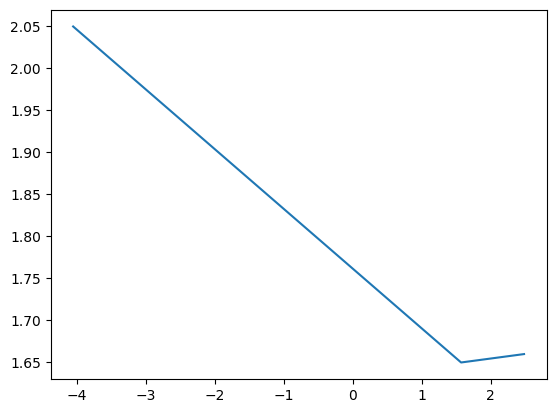

In [29]:
import matplotlib.pyplot as plt 
plt.plot([-4.0568, 1.5716, 2.485], [2.05, 1.65, 1.66])

In [53]:
from pymatgen.core import Composition
comp = Composition(comp)

NameError: name 'comp' is not defined

In [55]:
# comp = "Fe2O3"

In [52]:
from smact.metallicity import metallicity_score
comp

NameError: name 'comp' is not defined

In [50]:
print(Element("Cr").oxidation_states)
print(Element("Sb").oxidation_states)
print(Element("Zn").oxidation_states)

(-2, -1, 1, 2, 3, 4, 5, 6)
(-3, 3, 5)
(1, 2)


In [46]:
from pymatgen.core import Composition, Element
from smact.metallicity import metallicity_score
comp = processed_structures[18].formula
comp = Composition(comp)

In [56]:
Element("Sn").oxidation_states

(-4, 2, 4)

In [48]:
comp

Composition('Ac2 Sn2 H4 Ru1')

In [49]:
metallicity_score(comp)

np.float64(0.5635555555555556)

In [69]:
comp

Composition('Zn1 Cr1 Sb1')

Cr 2.4851934157866777
Sb -4.056811530387213
Zn 1.5716181146005348


In [76]:
# Cr 1.66	
# Sb 2.05
# Zn 1.65

SyntaxError: invalid syntax (2809863614.py, line 1)

In [36]:
for ind in invalid_indicies: 
    print(ind)
    print(electronegativity_correlation(processed_structures[ind]))

5
Pm
N
 
Pm1 Ho2 In1 N1
[1.23, 1.23, 1.78] [0.8883994385229415, 0.8883994385229415, 0] [Element Ho, Element Ho, Element In]
-1.0
13
Pm
Pm
H
Pt
Pt
Pt
Pt
Pt
 
Pm3 H1 Pt8
[1.13, 2.28, 2.28, 2.28] [0, 0, 0, 0] [Element Pm, Element Pt, Element Pt, Element Pt]
nan
18
Ac
Ac
H
H
H
H
 
Ac2 Sn2 H4 Ru1
[1.96, 1.96, 2.2] [0.07559239164961115, 0.07559239164961111, -2.357570472783806] [Element Sn, Element Sn, Element Ru]
-1.0
23
Pa
Pa
Se
Se
Se
Se
Se
Se
 
Sm4 Pa2 Se6
[1.17, 1.17, 1.17, 1.17] [2.5276281783210828, 2.497833623997544, 2.5184766782711177, 2.5184529253094152] [Element Sm, Element Sm, Element Sm, Element Sm]
nan
45
 
K2 Er4 S3 O2
[0.82, 0.82, 1.24, 1.24, 1.24, 1.24, 2.58, 2.58, 2.58, 3.44, 3.44] [0.6272319196897876, 0.627231919689787, 1.838034346049747, 1.8380343460497262, 1.8380343460497257, 1.8380343460497484, -2.3669734229555868, -1.2876827546929284, -1.2876827546929293, -1.8321311456185385, -1.8321311456185398] [Element K, Element K, Element Er, Element Er, Element Er, Element Er, Eleme

In [70]:
# check smact_validity metric 
for ind in invalid_indicies: 
    comp = processed_structures[ind].formula
    comp = Composition(comp)
    if smact_validity(comp):
        print(ind)
        print(comp)

70
Zn1 Cr1 Sb1
242
Tb1 Pr1 Sb2 Rh5
277
La4 Sb1 Ru1
280
Sr1 Sb1 Ru2
307
Lu1 Sb1 W2
364
Pr8 Tl2 Sb2
534
Ca1 Zr2 Sb1
590
Ta2 Re1 Sb1


In [40]:
test_inds

[5,
 13,
 18,
 23,
 80,
 97,
 134,
 220,
 273,
 320,
 322,
 341,
 387,
 435,
 440,
 475,
 517,
 519,
 526,
 618,
 655,
 742,
 763,
 772,
 850,
 871,
 898,
 955,
 960,
 966,
 978,
 983,
 1150,
 1184,
 1187,
 1231,
 1233,
 1274,
 1284,
 1338,
 1370,
 1377,
 1458,
 1542,
 1578,
 1582,
 1590,
 1618,
 1623,
 1633,
 1809,
 1833,
 1850,
 1865,
 1872,
 1925,
 1980,
 2018,
 2073,
 2087,
 2106,
 2119,
 2139,
 2195,
 2210,
 2261,
 2316,
 2343,
 2368,
 2429,
 2649,
 2655,
 2681,
 2686,
 2701,
 2735,
 2749,
 2756,
 2775,
 2796,
 2834,
 2919,
 3021,
 3045,
 3048,
 3112,
 3120,
 3138,
 3153,
 3179,
 3185,
 3246,
 3256,
 3281,
 3284,
 3347,
 3374,
 3409,
 3465,
 3477,
 3545,
 3551,
 3661,
 3675,
 3680,
 3710,
 3778,
 3779,
 3976,
 4011,
 4034,
 4109,
 4110,
 4140,
 4195,
 4199,
 4216,
 4231,
 4239,
 4242,
 4250,
 4269,
 4315,
 4350,
 4352,
 4419,
 4443,
 4458,
 4481,
 4552,
 4611,
 4615,
 4625,
 4661,
 4730,
 4743,
 4747,
 4748,
 4761,
 4762,
 4884,
 4915,
 4926,
 4952,
 4981,
 4997,
 5055,
 5112,
 51

In [41]:
invalid_indicies

[5,
 7,
 13,
 18,
 23,
 35,
 45,
 46,
 70,
 77,
 78,
 80,
 89,
 96,
 97,
 104,
 106,
 134,
 145,
 160,
 161,
 166,
 169,
 171,
 174,
 180,
 182,
 188,
 191,
 194,
 195,
 203,
 211,
 220,
 222,
 223,
 228,
 238,
 242,
 251,
 255,
 263,
 273,
 276,
 277,
 278,
 280,
 288,
 291,
 292,
 293,
 306,
 307,
 311,
 320,
 322,
 326,
 341,
 345,
 364,
 374,
 381,
 383,
 387,
 389,
 390,
 401,
 402,
 404,
 435,
 439,
 440,
 447,
 461,
 466,
 473,
 474,
 475,
 489,
 495,
 507,
 510,
 517,
 519,
 521,
 526,
 534,
 541,
 550,
 580,
 581,
 583,
 585,
 586,
 590,
 591,
 609,
 614,
 618,
 624,
 627,
 631,
 638,
 655,
 659,
 661,
 662,
 675,
 676,
 685,
 695,
 700,
 730,
 742,
 755,
 763,
 772,
 777,
 789,
 791,
 823,
 840,
 848,
 850,
 858,
 871,
 875,
 887,
 888,
 898,
 899,
 904,
 915,
 917,
 922,
 924,
 937,
 941,
 943,
 949,
 955,
 960,
 966,
 978,
 981,
 983,
 993,
 994,
 1016,
 1020,
 1021,
 1026,
 1031,
 1034,
 1044,
 1056,
 1062,
 1076,
 1079,
 1084,
 1087,
 1093,
 1097,
 1105,
 1111,
 1117,
 11